In [36]:
import pandas as pd
import numpy as np

import pickle

from mpl_toolkits.basemap import Basemap
from IPython.display import Image
import matplotlib.pyplot as plt

import sys
sys.setrecursionlimit(10000)
path = '/Volumes/ext200/Dropbox/metis/pklfiles/'

%matplotlib inline

# Zip code to county dataframe
from https://www.unitedstateszipcodes.org/zip-code-database/
county = County with the largest percentage of the ZIP population
approximate_latitude 	From the National Weather Service, precise to approximately 1 mile radius
approximate_longitude 	From the National Weather Service, precise to approximately 1 mile radius

In [2]:
# make a list of states (get rid of ones that don't use counties)
state_list_not_using =['PR','AA','VI','AE','GU','MP','PW', 'FM',  'MH','AS', 'AP', 'AK', 'DC']
state_list = ['NY', 'MA', 'RI', 'NH', 'ME', 'VT', 'CT', 'NJ','PA', 'DE',  'VA', 'MD', 
                  'WV', 'NC', 'SC', 'GA', 'FL','AL', 'TN', 'MS', 'KY', 'OH', 'IN', 'MI', 
                  'IA', 'WI', 'MN', 'SD','ND', 'MT', 'IL', 'MO', 'KS', 'NE', 'LA', 'AR', 
                  'OK', 'TX', 'CO','WY', 'ID', 'UT', 'AZ', 'NM','NV','CA', 'HI','OR','WA']

In [ ]:
def add_zeros_zips(x):
    """ Add zeros infront of zipcodes that are less than 5 digits. 
    They get cut off in the transfer.
    ------------------
    IN: x = a number
    OUT: zeros + x if x is too short  
      or  x 
         """
    for row in range(len(str(x))):
        if len(str(x)) == 1 :
            complete_zip = '0' +'0' + '0' + '0' + str(x)
            return complete_zip    
        elif len(str(x)) == 2 :
            complete_zip = '0' + '0' + '0' + str(x)
            return complete_zip    
        elif len(str(x)) == 3 :
            complete_zip =  '0' + '0' + str(x)
            return complete_zip 
        elif len(str(x)) == 4 :
            complete_zip =  '0' + str(x)
            return complete_zip
        else:
            return x

        
        
def remove_county(words):
    """ 
    remove the word County from the list of counties to help with matching. 
    -------
    IN: a string
    OUT: a lowercase string without the word ounty
    """
    name = str(words).replace(' County','')
    
    return name
        

    
    
def pull_zips(df,state_name):
    """extract rows that contain the specified state's initials and save the outputs as pickle files for lateruse
    -------------------------------
    IN: df = dataframe
        state_name = a string of the state's abbreviation (2 capital letters)
    Out: a dataframe of geographic information about each zipcode 
        an array zipcodes in that state"""
    zipcode_df = df.loc[(df.state == state_name)]
    zipcode_only = zipcode_df.zipcode.values    
    with open(path + state_name + '_zipcode_df.pkl', 'wb') as picklefile:
         pickle.dump(zipcode_df, picklefile)   
    with open(path + state_name + '_zips.pkl', 'wb') as picklefile:
         pickle.dump(zipcode_only, picklefile)        
    return zipcode_df, zipcode_only




def load_states_get_zips(df, state_list):
    """
    Run pull zips function to get relevant zipcode and county for each state
    ===========
    IN: df = dataframe
        state_list = list of strings containing 2-letter state abbreviations for USA
        """
    for state_name in state_list:
        pull_zips(df,state_name)    

In [ ]:
#open/clean/save raw csv file containing zipcode and county data

zips_raw = pd.read_csv('zip_code_database.csv') 

#add zeros back to zips that started with zero(s)
zips_raw['zip'] = zips_raw.loc[:,('zip')].apply(lambda i: add_zeros_zips(i)) 

#keep cols we want
zipcode_df = zips_raw.loc[:,['zip','state','county','primary_city',
                             'latitude','longitude', 
                             'irs_estimated_population_2014']]

#rename b/c zip is a function
zipcode_df.rename(columns = {zipcode_df.columns[0]:'zipcode'}, inplace=True) 

#get rid of 'county' for easier matching and plotting
zipcode_df['county'] = zipcode_df.loc[:,('county')].apply(lambda i: remove_county(i)) 

#save
with open(path + 'zipcode_df.pkl', 'wb') as picklefile:
    pickle.dump(zipcode_df, picklefile)

In [ ]:
#get state, zip, county and save to plk files for each state
load_states_get_zips(zipcode_df,state_list)

# Health Data by county

In [ ]:
health_raw = pd.read_csv('2017CHR_CSV_Analytic_Data.csv')

In [ ]:
def health_all(df_raw):
    """
    clean up raw health data for all states, save as pickle file
    -------------------------------
    IN: df = dataframe
    Out: a dataframe of health information about each county in state
    """
    
    # keep relevant columns and get rid of first row that is just more labels
    
    all_health = df_raw.loc[1:,['state','county','countycode',
                                'Adult obesity Value',
                                'Food environment index Value' ,   
                                'Access to exercise opportunities Value', 
                                'Some college Value', 
                                'Severe housing problems Value']]

    #get rid of 'county' for easier matching and plotting
    all_health['county'] = all_health.loc[:,('county')].apply(lambda i: remove_county(i))    
    
    #remove rows of state-wide aggregated data
    all_health = all_health.loc[(all_health.countycode != 0) & (all_health.countycode != '0')] 
    del all_health['countycode']
   
    return all_health






def st_health(df,state_names):
    
    """ get health data for each state, save as pickle file
    -------------------------------
    
    IN: df = dataframe 
    state_names = a list of strings of the state's abbreviation (2 capital letters)
    
    Out: a dataframe of health information about each county in state"""
   
    for state_name in state_names:
        st_health = df.loc[(df.state == state_name)]

     # save a pickle file _ Summer
        with open(path + state_name + '_health.pkl', 'wb') as picklefile:
            pickle.dump(st_health, picklefile) 

In [ ]:
# run fxn to clean up raw health data file
all_health = health_all(health_raw)

# get health data for each state
st_health(all_health,state_list)

#save 
with open(path +'health_all.pkl', 'wb') as picklefile:
         pickle.dump(health_all, picklefile)        

## SUM OVER ZIPS, COUNTIES, MERGE DATAFRAMES

In [24]:
def open_files(state_name):
    """ 
    takes in a string of 2-letter state abbreviation and opens 3 files needed for combination
    returns 3 dataframes in this order 1. health data, 2. zipcode_+county data 3. ymca locations 
    """
    
    #open health info
    with open(path + state_name +"_health.pkl", 'rb') as picklefile: 
        s_health = pickle.load(picklefile) 

    #zipcode+county info    
    with open(path + state_name +"_zipcode_df.pkl", 'rb') as picklefile: 
        s_zipcode_df = pickle.load(picklefile)    
        
    #ylocations
    with open(path + state_name +"_y.pkl", 'rb') as picklefile: 
        s_y = pickle.load(picklefile)      
        
    return s_health, s_zipcode_df, s_y   

In [25]:
def combine_dfs(state_name):
    """ 
    takes in a state abbreviation and opens up the 3 dataframes to merge them
    
    """
    #open the three files
    health_df, zipcode_df, y_locations = open_files(state_name)    
    
    #SUM number of ymca locations for each zip code 
    y_sum_zip = y_locations.groupby(['zipcode'],as_index=False).sum()
    
    #convert zips  to str, DONT MAKE AN INTEGER OR YOU LOSE THE LEADING ZEROS, 
    y_sum_zip['zipcode'] = y_sum_zip.loc[:,('zipcode')].apply(lambda i: str(i))        
    zipcode_df['zipcode'] = zipcode_df.loc[:,('zipcode')].apply(lambda i: str(i))    
    
    
    
    # merge ymca locations df with zipcode df via zipcode
    y_merge_county = y_sum_zip.merge(zipcode_df, left_on='zipcode',right_on='zipcode',how='left') 
  

    
    #SUM number of ymca locations for each county
    y_sum_county = y_merge_county.groupby(['county'], as_index=False).sum()
   
    #take out lat/long b/c now it's meaningless
    y_sum_county = y_sum_county.loc[:,['county','locations','irs_estimated_population_2014']] 
    
    
    
    # merge with health data via county name
    y_health = health_df.merge(y_sum_county, left_on='county',right_on='county', how='left')
    
    #counties with 0 y locations will have a NaN, replace with a zero
    y_health['locations'].fillna(0, inplace=True)
    
    
    
    # save files
    with open(path + state_name + '_yhealth.pkl', 'wb') as picklefile:
        pickle.dump(y_health, picklefile) 
    
    with open(path + state_name + '_yz_sums.pkl', 'wb') as picklefile:
        pickle.dump(y_merge_county, picklefile)     
    
    
    return   y_merge_county, y_health

In [26]:
def make_mega_df(state_names):
    """ 
    combine all states' full data frames into one US dataframe
    -------
    IN: state_names = list of state initials 
    OUT: combined data frame 
    """

    fdf = pd.DataFrame()   
    
    for state_name in state_names:
        
        # call fxn that merges all 3 dataframes
        full_st = combine_dfs(state_name)
        
        # concatenate the dataframes from each state into a big Dataframe
        framez = [fdf,full_st]
        fdf = pd.concat(framez)
    
    # convert all cols with numbers from str to float 
    
    fdf.iloc[:,-1] = fdf.iloc[:,-1].apply(pd.to_numeric)  
    fdf.iloc[:,2] = fdf.iloc[:,2].apply(pd.to_numeric) 
    fdf.loc[:,('Food environment index Value')] = fdf.loc[:,('Food environment index Value')].apply(pd.to_numeric)  
    fdf.loc[:,('Severe housing problems Value')] = fdf.loc[:,('Severe housing problems Value')].apply(pd.to_numeric) 
    fdf.loc[:,('Some college Value')] = fdf.loc[:,('Some college Value')].apply(pd.to_numeric)  
    fdf.loc[:,('Access to exercise opportunities Value')] = fdf.loc[:,('Access to exercise opportunities Value')].apply(pd.to_numeric)  
    
    #save
    with open(path + 'fdf.pkl', 'wb') as picklefile:
        pickle.dump(fdf, picklefile)      
        
    return fdf 

In [27]:
# a list of states that have YMCA location data 
states_finished = ['RI', 'CT', 'MS', 'MD', 'DE','HI','WY','NY',
                   'NV','NH','ID','UT','SD','MO','MT','NM' ,'OH',
                   'AZ','OR','AL','ND','LA'] #'IL',

In [29]:
# call function(s) that merges the dataframes into one
fdf= make_mega_df(states_finished)

** plot of locations vs. population example**

In [32]:
with open(path + "MO_zip_pop.pkl", 'rb') as picklefile: 
    MO = pickle.load(picklefile)

In [33]:
lat = MO['latitude'].values
lon = MO['longitude'].values
population = MO['irs_estimated_population_2014'].values
area = MO['locations'].values

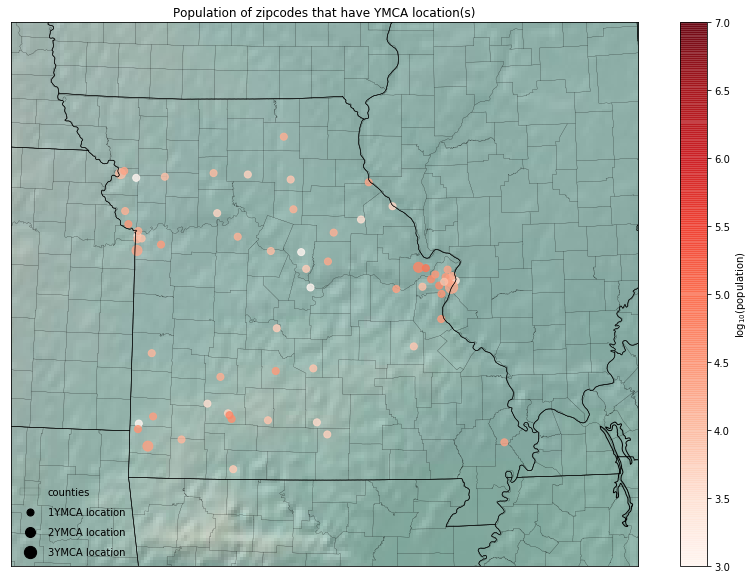

In [39]:
fig = plt.figure(figsize=(15, 10))

m = Basemap(projection='lcc',resolution='f',
           lat_0=38.5, lon_0=-92,
            width=.75E6, height=.65E6)
m.shadedrelief()
m.drawcoastlines(color='black')
m.drawcountries(color='black')
m.drawcounties(color='black');
m.drawstates(color='black')

# 2. scatter city data, with color reflecting population
# and size reflecting number of YMCA locations for that zipcode
m.scatter(lon, lat, latlon=True,
          c=np.log10(population), s=area*50,
          cmap='Reds', alpha=.8)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [1, 2, 3]:
    plt.scatter([], [], c='k', alpha=1, s=a*50,
                label=str(a) + 'YMCA location ')
    plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');
    plt.title('Population of zipcodes that have YMCA location(s)')